<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Asymmetric Noise 30%</h3>

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [2]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [3]:
noise_ratio = 0.3
loss_function = 'DampedMAELoss' 
dataset = 'aircrafts'
noise_type = 'asym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedMAELoss_aircrafts_asym_0.3_0.25_baseline
Model Features: DampedMAELoss_aircrafts_asym_0.3_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedMAELoss_aircrafts_asym_0.3_0.25
Csv save: DampedMAELoss_aircrafts_asym_0.3_0.25
Saving features from Scheme delta = 0.25: DampedMAELoss_aircrafts_asym_0.3_0.5
Saving csv for damp_2: DampedMAELoss_aircrafts_asym_0.3_0.5


# Declaration of Efficient Net family with Resolution, and Batch size 

In [3]:
architecture = 'efficientnet-b4'

effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [4]:
import pandas as pd
train_df = pd.read_csv(dataset+"_"+noise_type+"_"+str(noise_ratio)+".csv")
train_df

,Filepath,Noisy_labels,Label,Label_numeric
0,aircrafts_original/0/0716386.jpg,1,0,0
1,aircrafts_original/0/0810608.jpg,1,0,0
2,aircrafts_original/0/1427680.jpg,1,0,0
3,aircrafts_original/0/1017179.jpg,1,0,0
4,aircrafts_original/0/0536721.jpg,1,0,0
...,...,...,...,...
6662,aircrafts_original/99/1117057.jpg,99,99,99
6663,aircrafts_original/99/1026133.jpg,99,99,99
6664,aircrafts_original/99/0730106.jpg,99,99,99
6665,aircrafts_original/99/1801242.jpg,99,99,99


In [5]:
print(train_df.Noisy_labels.tolist())

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

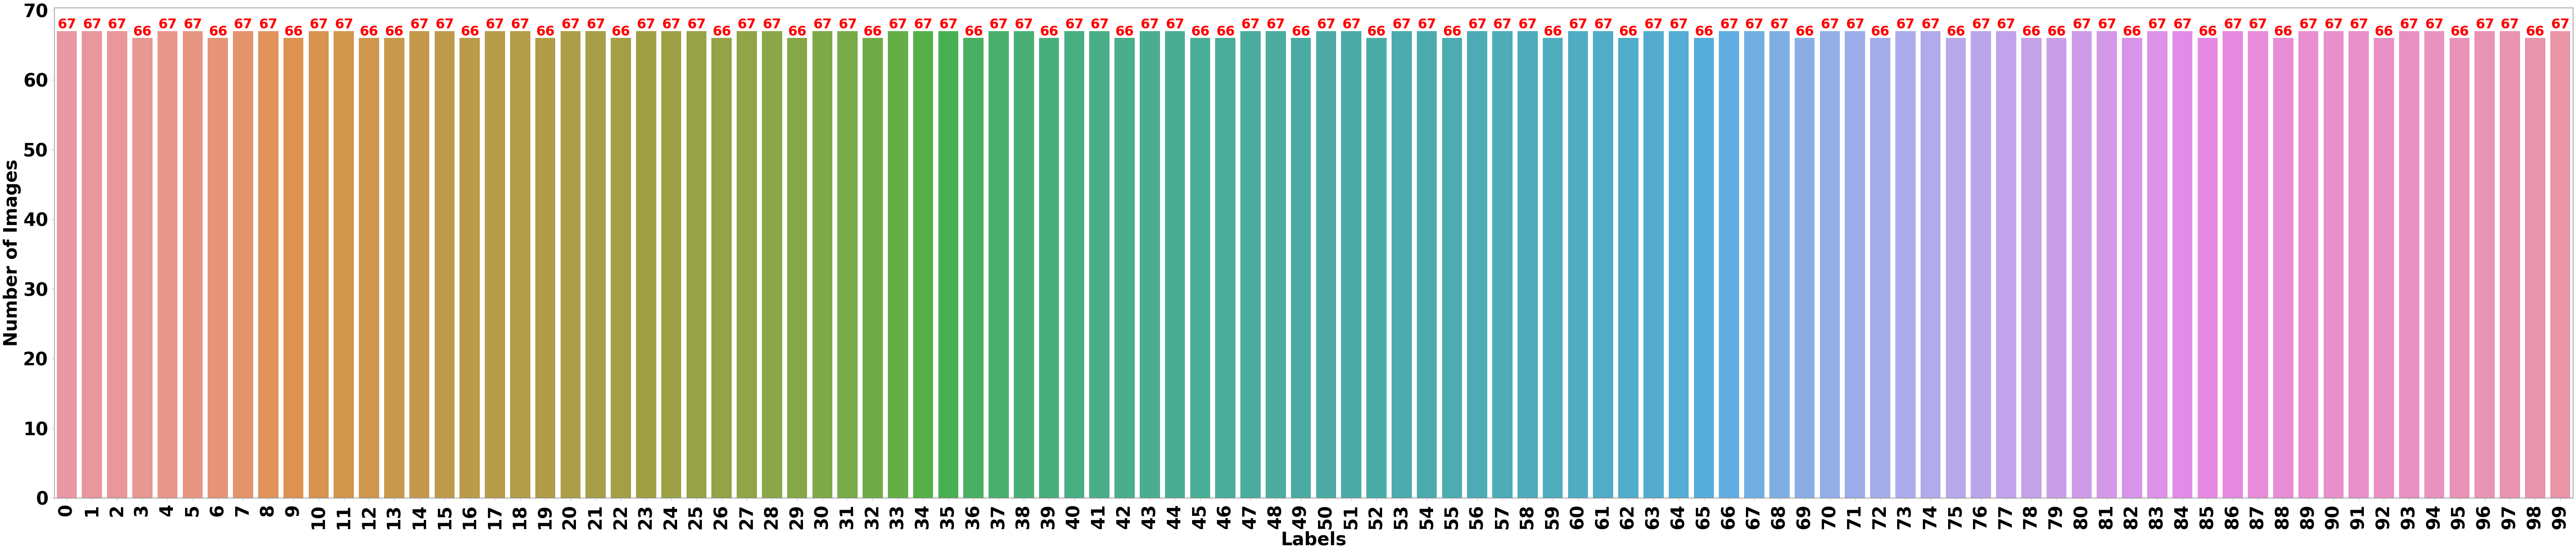

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(100,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Writing testing  Data into CSV  (Test data frame df)

In [8]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

,Filepath,Label
0,testing/32/1691545.jpg,32
1,testing/32/2212521.jpg,32
2,testing/32/1508910.jpg,32
3,testing/32/1260329.jpg,32
4,testing/32/0199985.jpg,32
...,...,...
3328,testing/42/0773394.jpg,42
3329,testing/42/0875337.jpg,42
3330,testing/42/0759282.jpg,42
3331,testing/42/2228007.jpg,42


Text(0, 0.5, 'Number of Images')

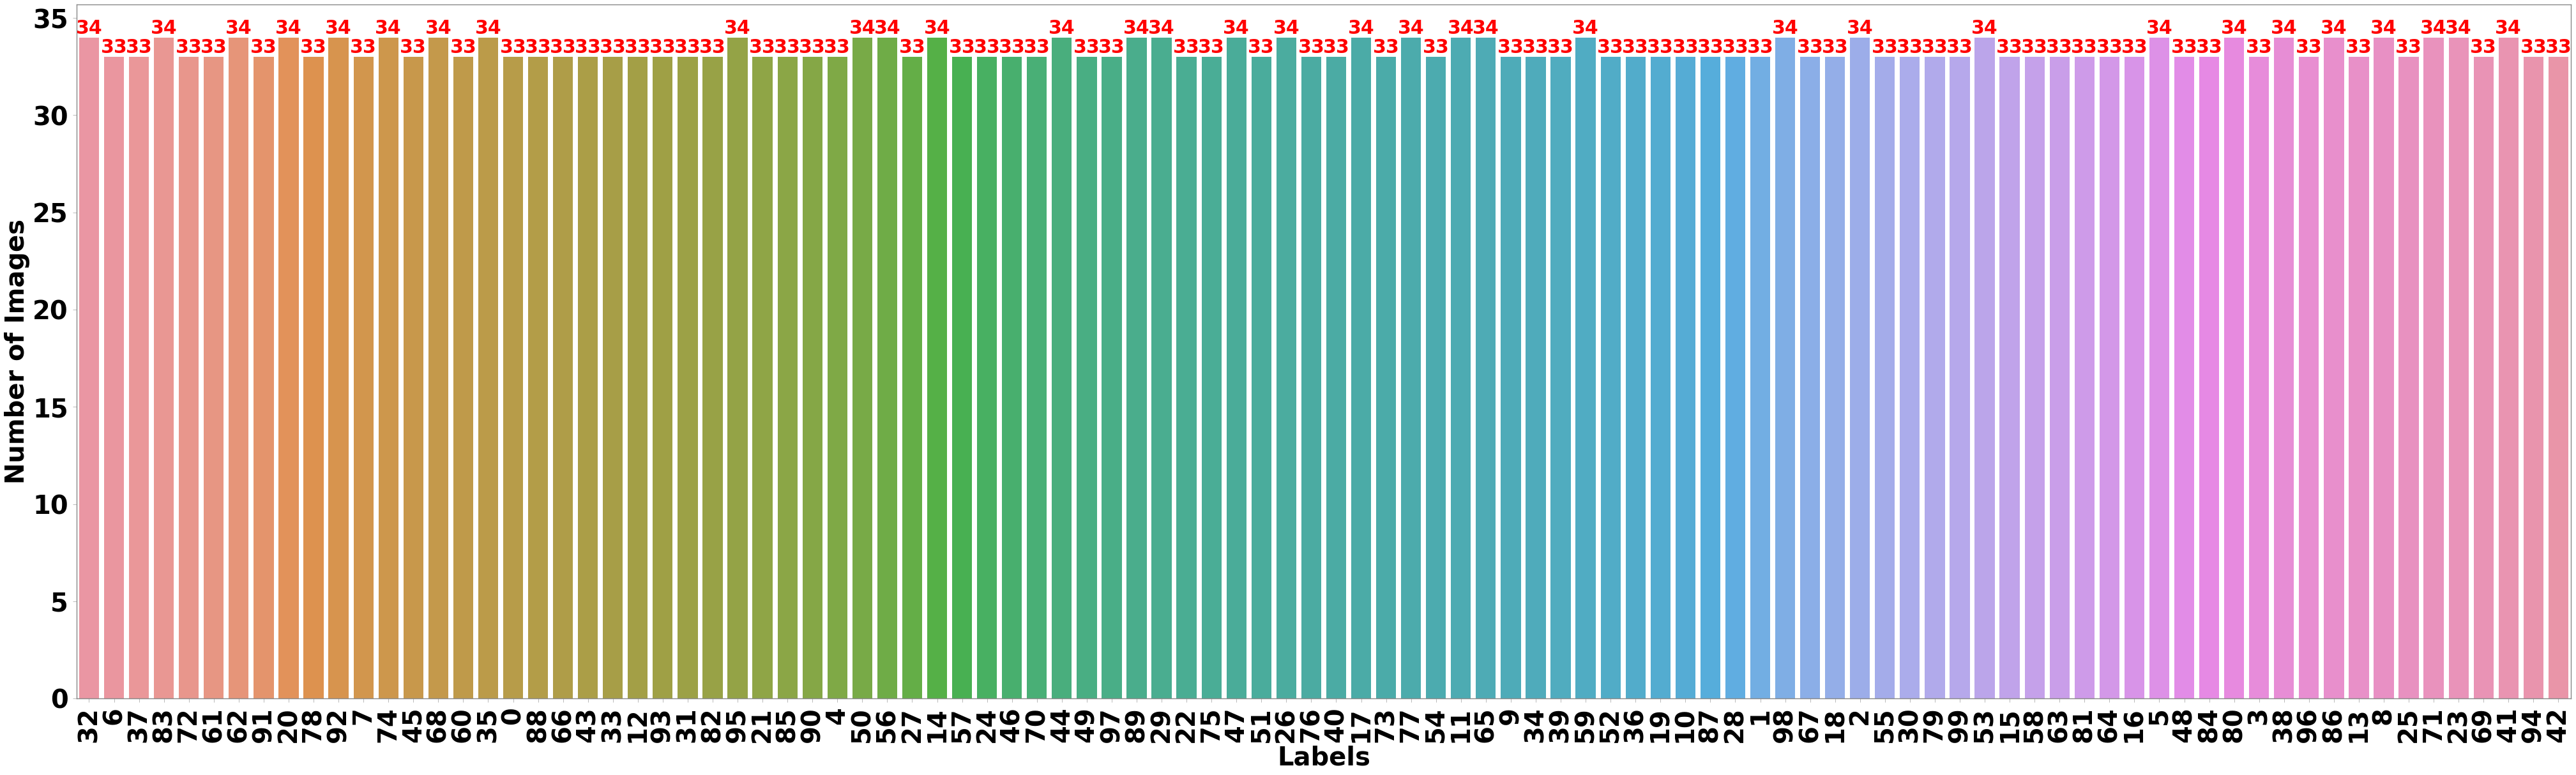

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [13]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [14]:

# default augmentation
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


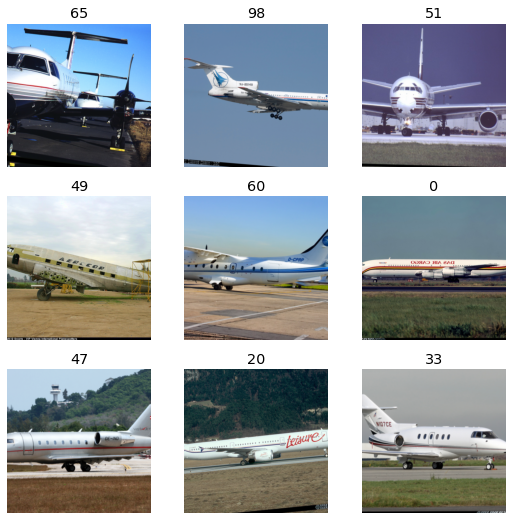

In [15]:
data0.show_batch()

In [16]:
import damped_losses as losses
loss_func = losses.DampedMAELossFlat(num_classes=num_classes,scale=20.0, delta = 0.0, reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=num_classes)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [17]:
best_pth = best_pth
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= mae_aircrafts_asym_0.3_baseline


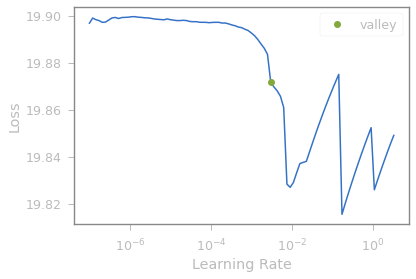

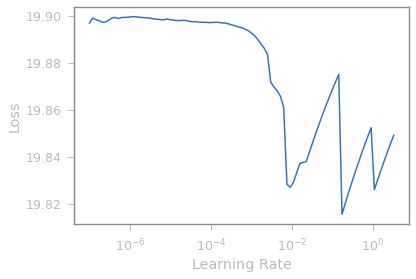

In [18]:
learn.lr_find()
learn.recorder.plot_lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,19.299133,18.846699,0.079520,01:50
1,19.128330,19.701122,0.015004,01:48
2,19.717789,19.707420,0.014254,01:49
3,19.843966,19.834002,0.009752,01:48
4,19.741308,19.607519,0.019505,01:48
5,19.682781,19.595385,0.020255,01:48
6,19.596470,19.518469,0.023256,01:48
7,19.481743,19.452473,0.027007,01:49
8,19.374434,19.408989,0.030008,01:49
9,19.403666,19.401058,0.030758,01:49


Better model found at epoch 0 with accuracy value: 0.07951988279819489.


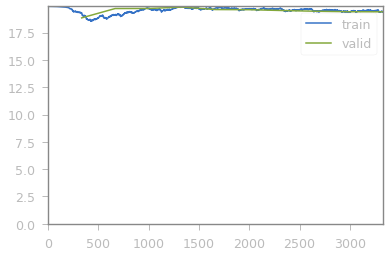

In [19]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

In [20]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,17.933899,17.830460,0.125281,01:49
1,17.309927,16.902246,0.179295,01:48
2,15.910909,15.976519,0.219055,01:48
3,14.942687,15.073650,0.251313,01:48
4,14.250548,14.811219,0.263316,01:49
5,13.956183,14.584380,0.278320,01:49
6,14.131296,16.058584,0.202551,01:48
7,14.228395,16.388107,0.183046,01:49
8,14.583122,16.438629,0.182296,01:49
9,14.823888,15.471785,0.228807,01:48


Better model found at epoch 0 with accuracy value: 0.12528131902217865.


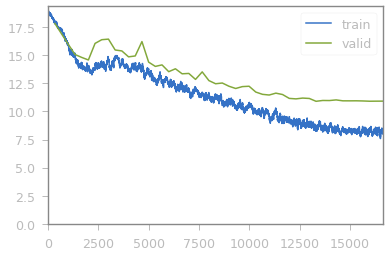

Better model found at epoch 1 with accuracy value: 0.17929482460021973.
Better model found at epoch 2 with accuracy value: 0.21905475854873657.
Better model found at epoch 3 with accuracy value: 0.25131282210350037.
Better model found at epoch 4 with accuracy value: 0.2633158266544342.
Better model found at epoch 5 with accuracy value: 0.2783195674419403.
Better model found at epoch 14 with accuracy value: 0.28582146763801575.
Better model found at epoch 15 with accuracy value: 0.3015753924846649.
Better model found at epoch 17 with accuracy value: 0.323330819606781.
Better model found at epoch 19 with accuracy value: 0.3338334560394287.
Better model found at epoch 21 with accuracy value: 0.35858964920043945.
Better model found at epoch 23 with accuracy value: 0.36759188771247864.
Better model found at epoch 24 with accuracy value: 0.37584397196769714.
Better model found at epoch 25 with accuracy value: 0.3765941560268402.
Better model found at epoch 26 with accuracy value: 0.389347344

In [21]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [22]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.5974)


In [23]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.6028)


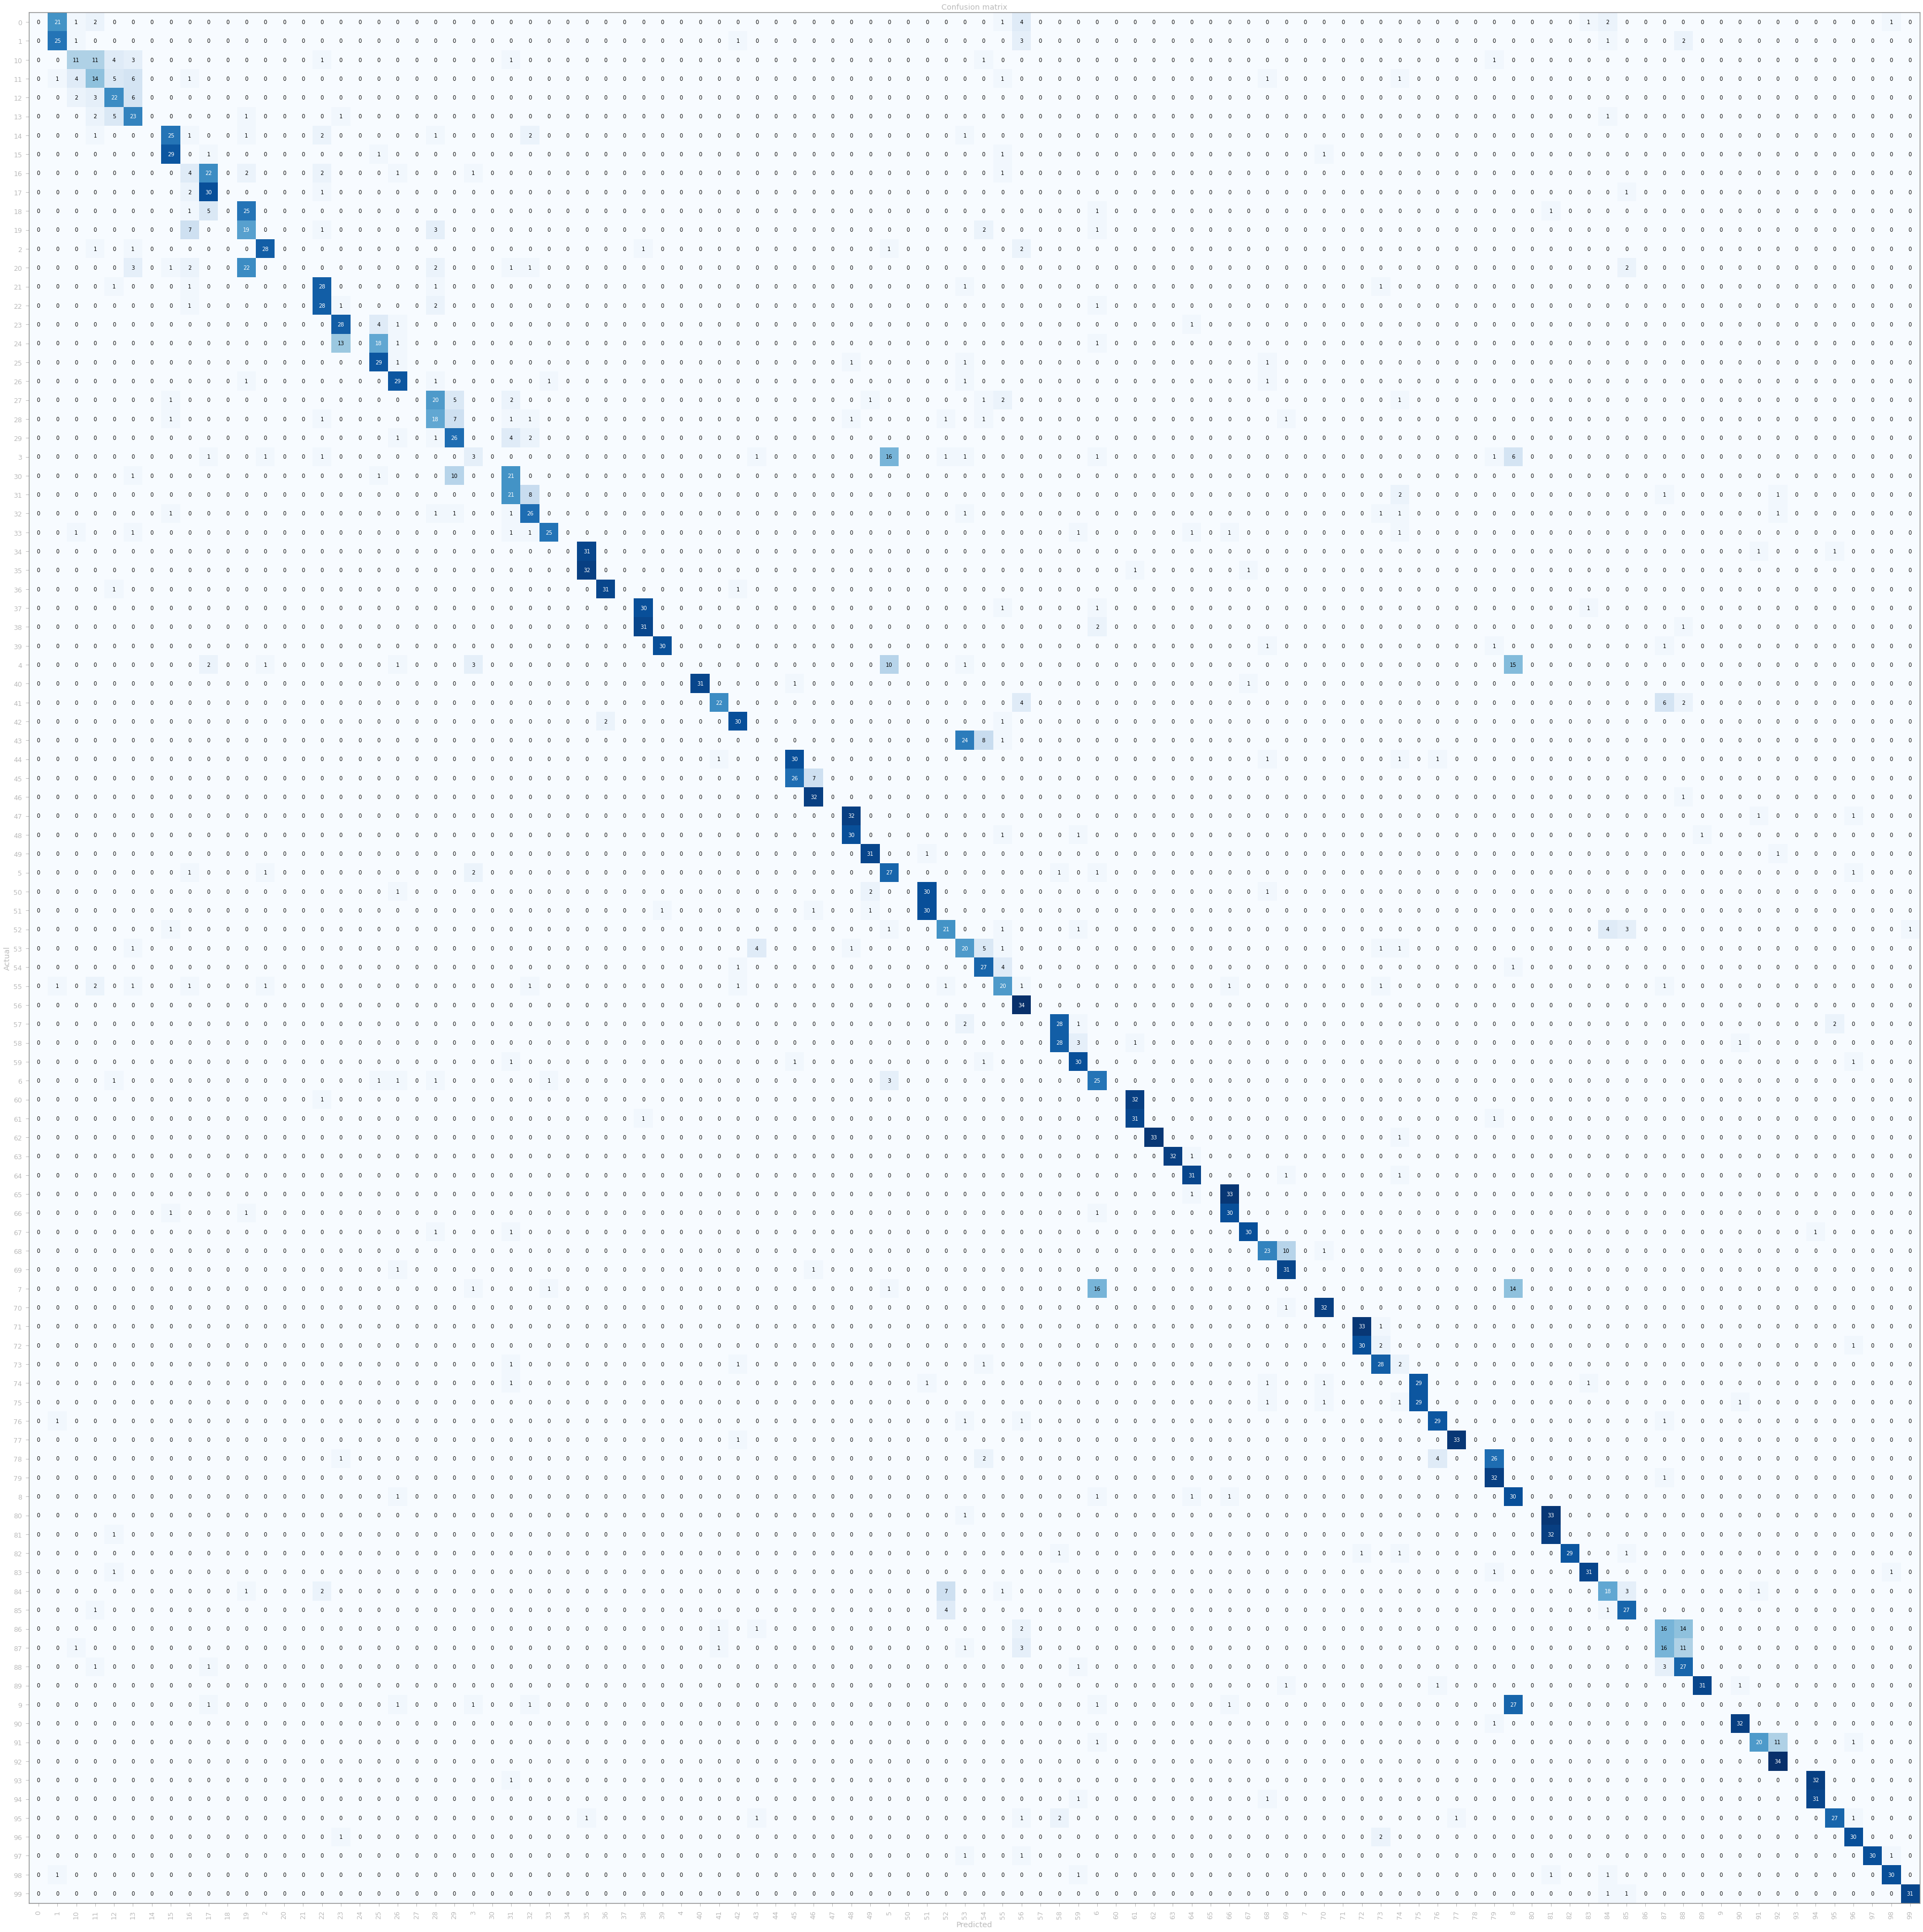

In [24]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [25]:
PATH='models/'+feature_path+'.p'
torch.save(model.state_dict(), PATH)

In [26]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/mae_aircrafts_asym_0.3_baseline.pth'

In [27]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering

def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
        #print(f'Frequency of class {cl}: {class_freq[cl]} ')
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
#         print("+++++++++ L", l)
#         prob = min_prob + deltap * (class_freq[l]**2)
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
#         print("rrr",r, "prob+++", prob)
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
#     print(class_freq)# returns number of images per class
    return drop_idx

def data_definition(data,imgs,tfms,model,best_pth,k_samples=k_samples, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

#     
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
#     entire_training_set_learner0 = (learner_type(entire_training_set_csv0, model, metrics=[accuracy]).to_fp16())
#     entire_training_set_learner0.load(best_pth)
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    

#     interp.plot_top_losses(100, figsize = (11,15))
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered


# Dump 0.25 with Cleaning Scheme

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 44 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6623


epoch,train_loss,valid_loss,accuracy,time
0,8.895093,8.269985,0.586103,01:51


Better model found at epoch 0 with accuracy value: 0.5861027240753174.


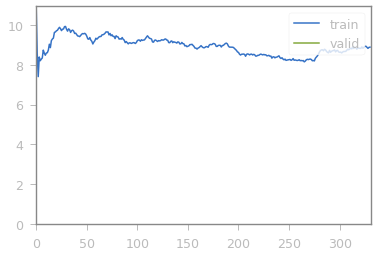

************Round:  0
TTA Accuracy:0.6018601655960083
cycle 0 Error Rate is [{0: (0.6599670016499193, 39.81398344039917)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 34 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6589


epoch,train_loss,valid_loss,accuracy,time
0,8.783295,8.551173,0.572513,01:48


Better model found at epoch 0 with accuracy value: 0.5725132822990417.


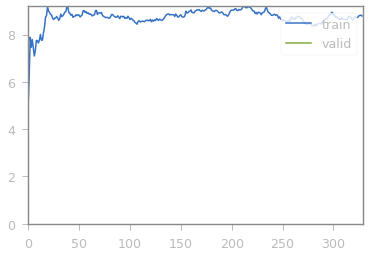

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 41
Min probability = 0.5507462686567164
Dropped 28 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6561


epoch,train_loss,valid_loss,accuracy,time
0,8.739572,8.889750,0.555640,01:48


Better model found at epoch 0 with accuracy value: 0.5556402206420898.


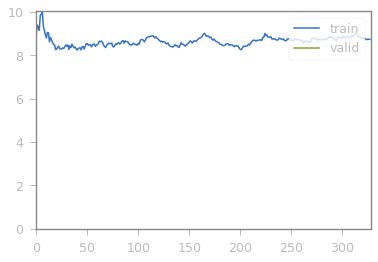

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 36
Min probability = 0.4835820895522388
Dropped 24 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6537


epoch,train_loss,valid_loss,accuracy,time
0,8.532464,8.064820,0.596021,01:47


Better model found at epoch 0 with accuracy value: 0.5960214138031006.


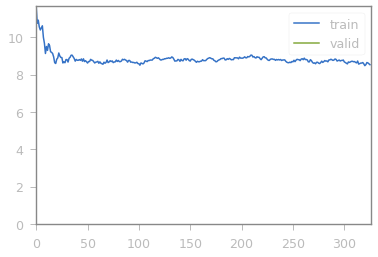

************Round:  3
TTA Accuracy:0.6090608835220337
cycle 0 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 33
Min probability = 0.4432835820895522
Dropped 21 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6516


epoch,train_loss,valid_loss,accuracy,time
0,9.039921,7.863968,0.607828,01:48


Better model found at epoch 0 with accuracy value: 0.6078280806541443.


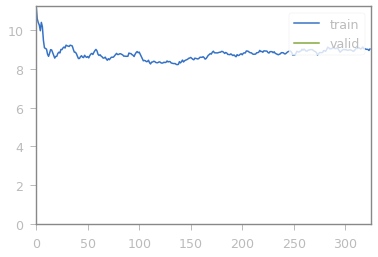

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 27
Min probability = 0.36268656716417913
Dropped 20 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6496


epoch,train_loss,valid_loss,accuracy,time
0,8.792301,8.253877,0.588915,01:48


Better model found at epoch 0 with accuracy value: 0.5889145731925964.


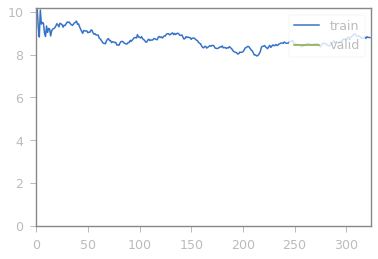

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 26
Min probability = 0.3492537313432836
Dropped 19 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6477


epoch,train_loss,valid_loss,accuracy,time
0,9.082133,8.295321,0.586100,01:48


Better model found at epoch 0 with accuracy value: 0.5861003994941711.


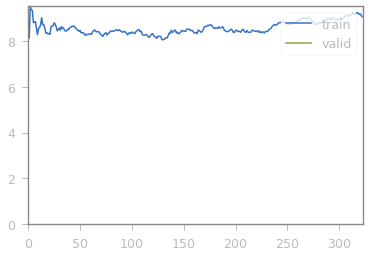

************Round:  6
TTA Accuracy:0.6090608835220337
cycle 0 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 18
Min probability = 0.2417910447761194
Dropped 11 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6466


epoch,train_loss,valid_loss,accuracy,time
0,8.573092,8.136588,0.593967,01:47


Better model found at epoch 0 with accuracy value: 0.5939674973487854.


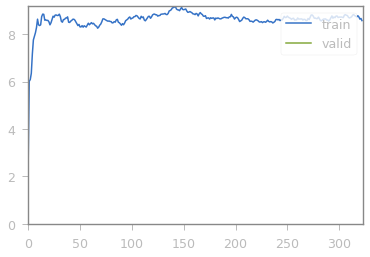

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 18
Min probability = 0.2417910447761194
Dropped 13 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6453


epoch,train_loss,valid_loss,accuracy,time
0,8.659211,8.017456,0.600775,01:48


Better model found at epoch 0 with accuracy value: 0.6007751822471619.


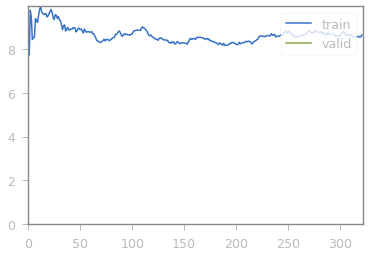

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 18
Min probability = 0.2417910447761194
Dropped 12 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6441


epoch,train_loss,valid_loss,accuracy,time
0,8.572071,8.221398,0.589286,01:47


Better model found at epoch 0 with accuracy value: 0.5892857313156128.


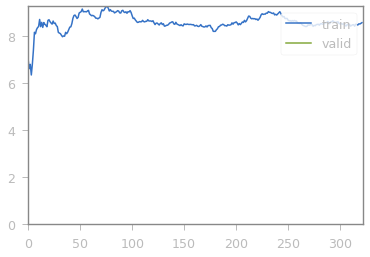

************Round:  9
TTA Accuracy:0.6156615614891052
cycle 0 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 17
Min probability = 0.2283582089552239
Dropped 14 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6427


epoch,train_loss,valid_loss,accuracy,time
0,8.266178,8.135683,0.593774,01:45


Better model found at epoch 0 with accuracy value: 0.5937743186950684.


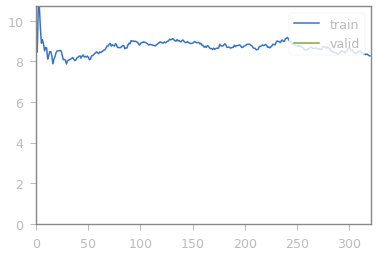

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 15
Min probability = 0.20149253731343283
Dropped 15 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6412


epoch,train_loss,valid_loss,accuracy,time
0,7.904455,8.067115,0.596724,01:45


Better model found at epoch 0 with accuracy value: 0.5967238545417786.


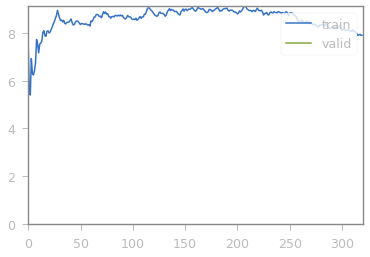

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 13
Min probability = 0.1746268656716418
Dropped 12 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6400


epoch,train_loss,valid_loss,accuracy,time
0,8.688299,8.096573,0.596875,01:45


Better model found at epoch 0 with accuracy value: 0.596875011920929.


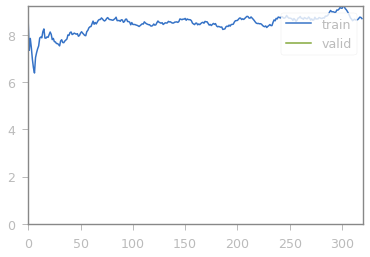

************Round:  12
TTA Accuracy:0.6144614219665527
cycle 0 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 11
Min probability = 0.14776119402985075
Dropped 8 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6392


epoch,train_loss,valid_loss,accuracy,time
0,8.423187,7.986143,0.600939,01:47


Better model found at epoch 0 with accuracy value: 0.6009389758110046.


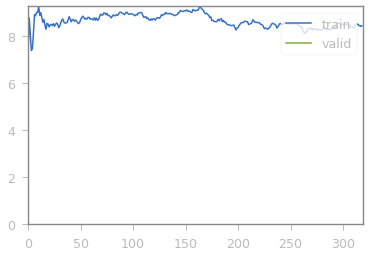

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 10
Min probability = 0.13432835820895522
Dropped 3 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6389


epoch,train_loss,valid_loss,accuracy,time
0,8.769642,8.283635,0.585748,01:45


Better model found at epoch 0 with accuracy value: 0.5857478380203247.


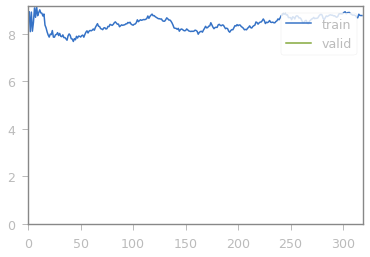

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 45 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6622


epoch,train_loss,valid_loss,accuracy,time
0,8.393295,7.696376,0.617069,01:49


Better model found at epoch 0 with accuracy value: 0.6170694828033447.


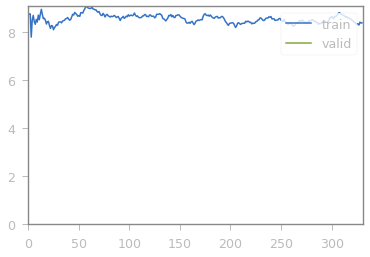

************Round:  0
TTA Accuracy:0.6123612523078918
cycle 1 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473), 15: (0.6749662516874144, 38.763874769210815)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 33 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6589


epoch,train_loss,valid_loss,accuracy,time
0,8.323591,8.259721,0.589977,01:48


Better model found at epoch 0 with accuracy value: 0.5899772047996521.


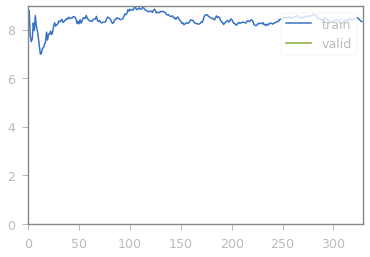

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 41
Min probability = 0.5507462686567164
Dropped 31 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6558


epoch,train_loss,valid_loss,accuracy,time
0,8.796763,8.061246,0.598780,01:47


Better model found at epoch 0 with accuracy value: 0.598779559135437.


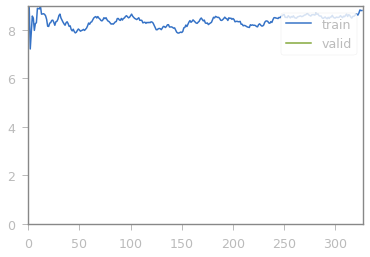

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 33
Min probability = 0.4432835820895522
Dropped 19 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6539


epoch,train_loss,valid_loss,accuracy,time
0,8.382855,8.051898,0.599847,01:47


Better model found at epoch 0 with accuracy value: 0.5998469591140747.


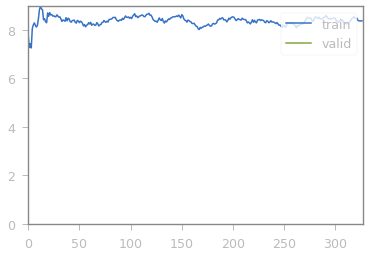

************Round:  3
TTA Accuracy:0.6129612922668457
cycle 1 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473), 15: (0.6749662516874144, 38.763874769210815), 18: (1.919904004799755, 38.70387077331543)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 30
Min probability = 0.40298507462686567
Dropped 16 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6523


epoch,train_loss,valid_loss,accuracy,time
0,8.244281,8.411582,0.581288,01:47


Better model found at epoch 0 with accuracy value: 0.5812883377075195.


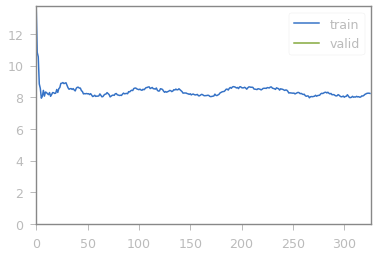

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 28
Min probability = 0.3761194029850746
Dropped 19 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6504


epoch,train_loss,valid_loss,accuracy,time
0,8.685336,7.975832,0.601538,01:48


Better model found at epoch 0 with accuracy value: 0.6015384793281555.


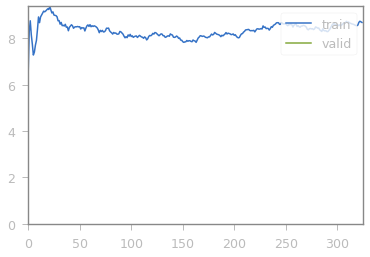

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 23
Min probability = 0.30895522388059704
Dropped 15 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6489


epoch,train_loss,valid_loss,accuracy,time
0,8.060501,8.039566,0.598304,01:48


Better model found at epoch 0 with accuracy value: 0.5983037948608398.


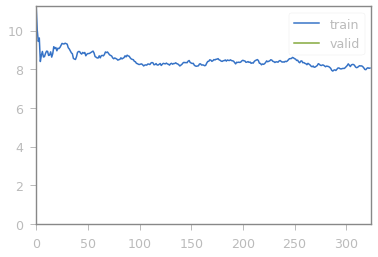

************Round:  6
TTA Accuracy:0.6126612424850464
cycle 1 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473), 15: (0.6749662516874144, 38.763874769210815), 18: (1.919904004799755, 38.70387077331543), 21: (2.6698665066746674, 38.73387575149536)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 22
Min probability = 0.2955223880597015
Dropped 15 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6474


epoch,train_loss,valid_loss,accuracy,time
0,8.176195,7.701836,0.616692,01:46


Better model found at epoch 0 with accuracy value: 0.6166924238204956.


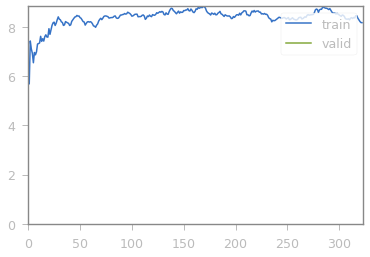

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 22
Min probability = 0.2955223880597015
Dropped 8 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6466


epoch,train_loss,valid_loss,accuracy,time
0,7.938472,8.245383,0.590101,01:46


Better model found at epoch 0 with accuracy value: 0.5901005268096924.


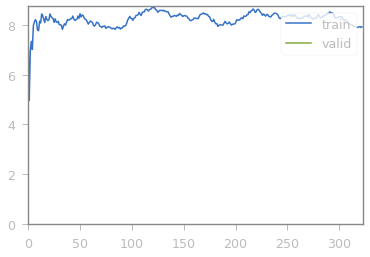

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 19
Min probability = 0.2552238805970149
Dropped 11 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6455


epoch,train_loss,valid_loss,accuracy,time
0,8.341516,8.140964,0.593338,01:45


Better model found at epoch 0 with accuracy value: 0.5933384895324707.


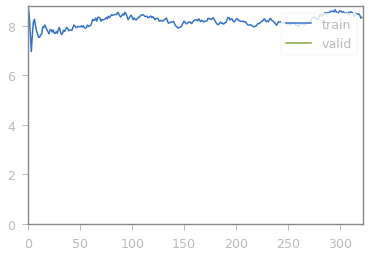

************Round:  9
TTA Accuracy:0.6177617907524109
cycle 1 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473), 15: (0.6749662516874144, 38.763874769210815), 18: (1.919904004799755, 38.70387077331543), 21: (2.6698665066746674, 38.73387575149536), 24: (3.179841007949602, 38.22382092475891)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 18
Min probability = 0.2417910447761194
Dropped 11 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6444


epoch,train_loss,valid_loss,accuracy,time
0,8.443807,7.860778,0.607919,01:45


Better model found at epoch 0 with accuracy value: 0.6079192757606506.


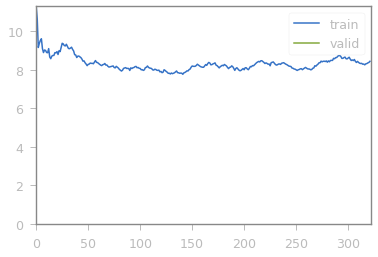

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 18
Min probability = 0.2417910447761194
Dropped 11 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6433


epoch,train_loss,valid_loss,accuracy,time
0,8.200524,7.845419,0.610420,01:47


Better model found at epoch 0 with accuracy value: 0.6104199290275574.


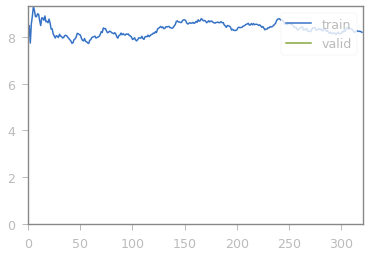

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 17
Min probability = 0.2283582089552239
Dropped 8 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6425


epoch,train_loss,valid_loss,accuracy,time
0,8.137489,8.151950,0.592218,01:45


Better model found at epoch 0 with accuracy value: 0.5922179222106934.


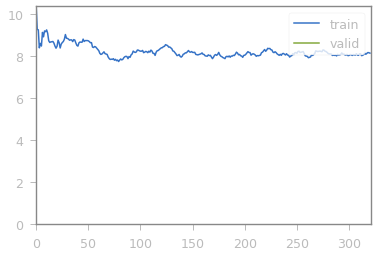

************Round:  12
TTA Accuracy:0.6213621497154236
cycle 1 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473), 15: (0.6749662516874144, 38.763874769210815), 18: (1.919904004799755, 38.70387077331543), 21: (2.6698665066746674, 38.73387575149536), 24: (3.179841007949602, 38.22382092475891), 27: (3.629818509074545, 37.86378502845764)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 17
Min probability = 0.2283582089552239
Dropped 15 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6410


epoch,train_loss,valid_loss,accuracy,time
0,8.006237,8.027108,0.601404,01:45


Better model found at epoch 0 with accuracy value: 0.601404070854187.


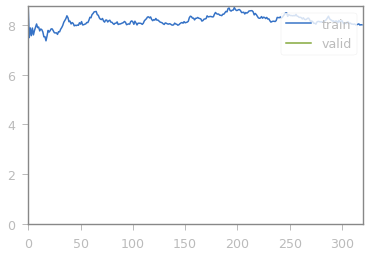

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 16
Min probability = 0.21492537313432836
Dropped 9 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6401


epoch,train_loss,valid_loss,accuracy,time
0,8.234752,8.104448,0.596094,01:45


Better model found at epoch 0 with accuracy value: 0.5960937738418579.


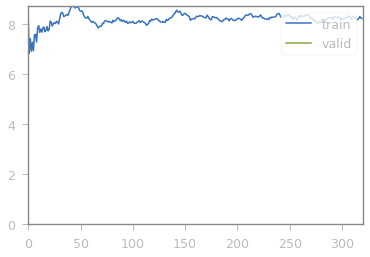

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 43 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6624


epoch,train_loss,valid_loss,accuracy,time
0,8.075888,7.902650,0.605740,01:48


Better model found at epoch 0 with accuracy value: 0.6057401895523071.


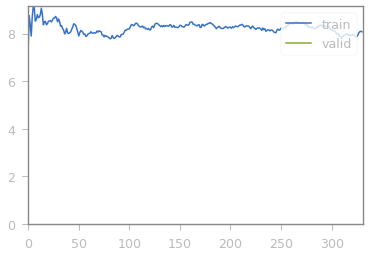

************Round:  0
TTA Accuracy:0.6201620101928711
cycle 2 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473), 15: (0.6749662516874144, 38.763874769210815), 18: (1.919904004799755, 38.70387077331543), 21: (2.6698665066746674, 38.73387575149536), 24: (3.179841007949602, 38.22382092475891), 27: (3.629818509074545, 37.86378502845764), 30: (0.6449677516124241, 37.98379898071289)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 33 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6591


epoch,train_loss,valid_loss,accuracy,time
0,8.444713,8.033016,0.602428,01:48


Better model found at epoch 0 with accuracy value: 0.6024278998374939.


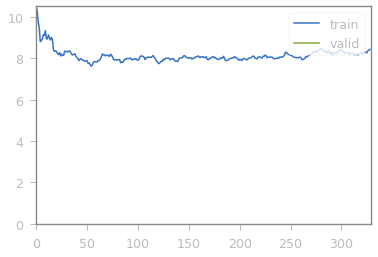

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 24 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6567


epoch,train_loss,valid_loss,accuracy,time
0,8.174462,8.063054,0.597106,01:47


Better model found at epoch 0 with accuracy value: 0.597105860710144.


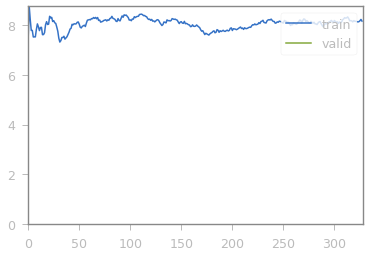

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 33
Min probability = 0.4432835820895522
Dropped 22 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6545


epoch,train_loss,valid_loss,accuracy,time
0,7.820775,7.833012,0.608862,01:47


Better model found at epoch 0 with accuracy value: 0.6088617444038391.


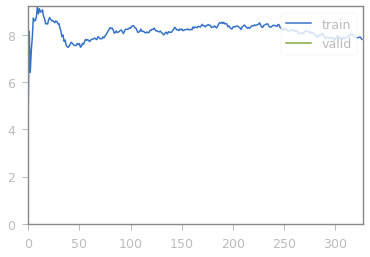

************Round:  3
TTA Accuracy:0.6192619204521179
cycle 2 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473), 15: (0.6749662516874144, 38.763874769210815), 18: (1.919904004799755, 38.70387077331543), 21: (2.6698665066746674, 38.73387575149536), 24: (3.179841007949602, 38.22382092475891), 27: (3.629818509074545, 37.86378502845764), 30: (0.6449677516124241, 37.98379898071289), 33: (1.8299085045747732, 38.07380795478821)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 27
Min probability = 0.36268656716417913
Dropped 20 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6525


epoch,train_loss,valid_loss,accuracy,time
0,7.795735,8.188671,0.593870,01:48


Better model found at epoch 0 with accuracy value: 0.5938697457313538.


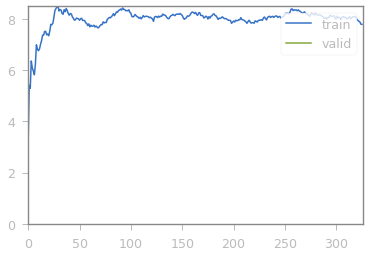

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 24
Min probability = 0.32238805970149254
Dropped 24 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6501


epoch,train_loss,valid_loss,accuracy,time
0,7.979017,7.684817,0.617692,01:47


Better model found at epoch 0 with accuracy value: 0.6176922917366028.


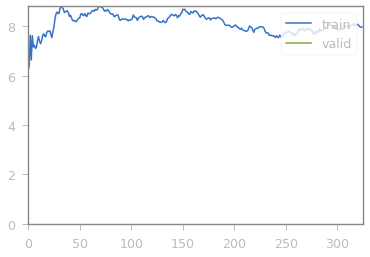

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 21
Min probability = 0.282089552238806
Dropped 15 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6486


epoch,train_loss,valid_loss,accuracy,time
0,8.397831,7.877459,0.607556,01:47


Better model found at epoch 0 with accuracy value: 0.6075559258460999.


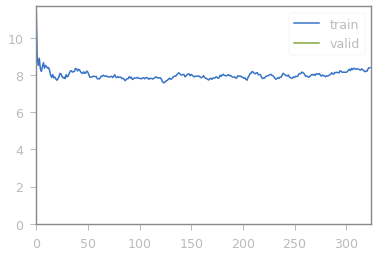

************Round:  6
TTA Accuracy:0.6168617010116577
cycle 2 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473), 15: (0.6749662516874144, 38.763874769210815), 18: (1.919904004799755, 38.70387077331543), 21: (2.6698665066746674, 38.73387575149536), 24: (3.179841007949602, 38.22382092475891), 27: (3.629818509074545, 37.86378502845764), 30: (0.6449677516124241, 37.98379898071289), 33: (1.8299085045747732, 38.07380795478821), 36: (2.714864256787164, 38.31382989883423)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 19
Min probability = 0.2552238805970149
Dropped 13 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6473


epoch,train_loss,valid_loss,accuracy,time
0,7.873310,7.859747,0.608192,01:47


Better model found at epoch 0 with accuracy value: 0.6081916689872742.


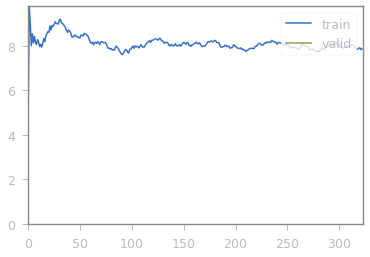

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 17
Min probability = 0.2283582089552239
Dropped 11 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6462


epoch,train_loss,valid_loss,accuracy,time
0,7.930870,7.847814,0.609907,01:47


Better model found at epoch 0 with accuracy value: 0.6099071502685547.


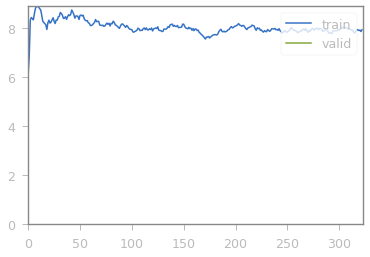

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 16
Min probability = 0.21492537313432836
Dropped 13 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6449


epoch,train_loss,valid_loss,accuracy,time
0,7.929965,7.438996,0.629170,01:46


Better model found at epoch 0 with accuracy value: 0.6291698813438416.


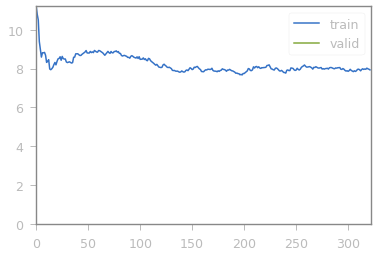

************Round:  9
TTA Accuracy:0.6156615614891052
cycle 2 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473), 15: (0.6749662516874144, 38.763874769210815), 18: (1.919904004799755, 38.70387077331543), 21: (2.6698665066746674, 38.73387575149536), 24: (3.179841007949602, 38.22382092475891), 27: (3.629818509074545, 37.86378502845764), 30: (0.6449677516124241, 37.98379898071289), 33: (1.8299085045747732, 38.07380795478821), 36: (2.714864256787164, 38.31382989883423), 39: (3.269836508174595, 38.43384385108948)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 15
Min probability = 0.20149253731343283
Dropped 8 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6441


epoch,train_loss,valid_loss,accuracy,time
0,7.981869,7.696294,0.616460,01:46


Better model found at epoch 0 with accuracy value: 0.6164596080780029.


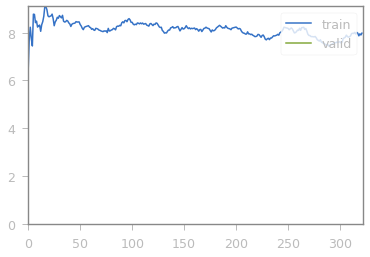

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 14
Min probability = 0.1880597014925373
Dropped 10 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6431


epoch,train_loss,valid_loss,accuracy,time
0,8.242344,7.796651,0.610420,01:45


Better model found at epoch 0 with accuracy value: 0.6104199290275574.


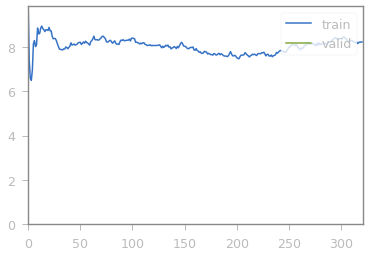

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 12
Min probability = 0.16119402985074627
Dropped 7 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6424


epoch,train_loss,valid_loss,accuracy,time
0,8.014899,7.743186,0.614486,01:45


Better model found at epoch 0 with accuracy value: 0.6144859790802002.


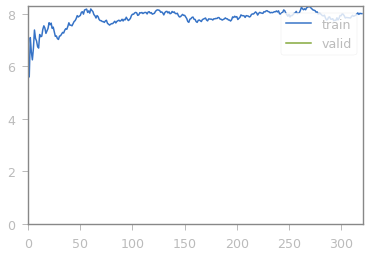

************Round:  12
TTA Accuracy:0.6183618307113647
cycle 2 Error Rate is [{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473), 15: (0.6749662516874144, 38.763874769210815), 18: (1.919904004799755, 38.70387077331543), 21: (2.6698665066746674, 38.73387575149536), 24: (3.179841007949602, 38.22382092475891), 27: (3.629818509074545, 37.86378502845764), 30: (0.6449677516124241, 37.98379898071289), 33: (1.8299085045747732, 38.07380795478821), 36: (2.714864256787164, 38.31382989883423), 39: (3.269836508174595, 38.43384385108948), 42: (3.64481775911204, 38.163816928863525)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 11
Min probability = 0.14776119402985075
Dropped 8 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6416


epoch,train_loss,valid_loss,accuracy,time
0,8.192998,7.301338,0.636789,01:45


Better model found at epoch 0 with accuracy value: 0.6367887854576111.


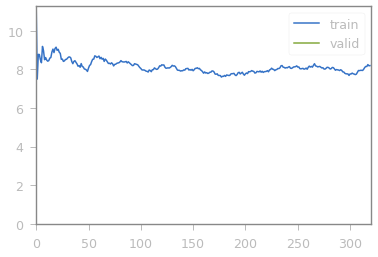

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 10
Min probability = 0.13432835820895522
Dropped 10 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6406


epoch,train_loss,valid_loss,accuracy,time
0,8.101906,7.869679,0.607338,01:45


Better model found at epoch 0 with accuracy value: 0.607338011264801.


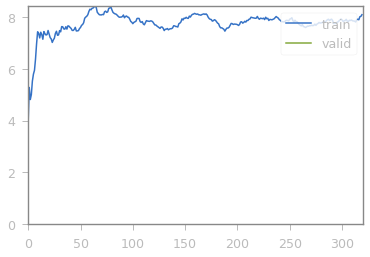

In [28]:
drop_idxx = []
los = []
top_losses = []
n_training_series = 15  # orginally it is 15, but for testing purpose we are using with 1 to check the scheme with custom function.
min_epochs = 1
min_prob=0.5
max_prob=0.9
delta_epochs_per_serie =  0
min_lr = 1e-4
kappa_lr = 1 
k_samples = 0
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
cleaning_cycles = 3 
delta_max = 0.25
accs = []
deltas = []
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
#         print(f'delta = {delta}')
        loss_func = losses.DampedMAELossFlat(num_classes=num_classes,scale=20.0, delta = delta, reduction='mean')
        
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
#         print("dynamic LR", dynamic_lr)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
    #     data_per_serie[n+1]
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

    #     learn = ( learner_type(databunch, model,metrics=[accuracy,top_5],loss_func=loss,cbs=[ShowGraphCallback(),history]).to_fp16())
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
#         learn.split( lambda m: (model._conv_head) )
        learn.unfreeze() 
        learn.load(best_pth)
#         learn.fit_one_cycle(epochs_per_serie, max_lr=slice(min_lr,lr),cbs=[SaveModelCallback(learn,metrics=[accuracy], name=best_pth)])
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
        
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
#             inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
#             inter_test.plot_confusion_matrix(figsize = (10,10))
            PATH='models/'+damp_1_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_1_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)     
    

In [29]:
# err = {}
print(err)

{0: (0.6599670016499193, 39.81398344039917), 3: (1.9499025048747565, 39.09391164779663), 6: (2.8498575071246424, 39.09391164779663), 9: (3.3898305084745783, 38.43384385108948), 12: (4.004799760012001, 38.55385780334473), 15: (0.6749662516874144, 38.763874769210815), 18: (1.919904004799755, 38.70387077331543), 21: (2.6698665066746674, 38.73387575149536), 24: (3.179841007949602, 38.22382092475891), 27: (3.629818509074545, 37.86378502845764), 30: (0.6449677516124241, 37.98379898071289), 33: (1.8299085045747732, 38.07380795478821), 36: (2.714864256787164, 38.31382989883423), 39: (3.269836508174595, 38.43384385108948), 42: (3.64481775911204, 38.163816928863525)}


In [30]:
for i in range(len(accs)):
    print(f'acc:{accs[i]}, delta:{deltas[i]}')

acc:0.6018601655960083, delta:0.05197792270443983
acc:0.6090608835220337, delta:0.18578620636934853
acc:0.6090608835220337, delta:0.24863047384206832
acc:0.6156615614891052, delta:0.21650635094610968
acc:0.6144614219665527, delta:0.10168416076895001
acc:0.6123612523078918, delta:0.05197792270443983
acc:0.6129612922668457, delta:0.18578620636934853
acc:0.6126612424850464, delta:0.24863047384206832
acc:0.6177617907524109, delta:0.21650635094610968
acc:0.6213621497154236, delta:0.10168416076895001
acc:0.6201620101928711, delta:0.05197792270443983
acc:0.6192619204521179, delta:0.18578620636934853
acc:0.6168617010116577, delta:0.24863047384206832
acc:0.6156615614891052, delta:0.21650635094610968
acc:0.6183618307113647, delta:0.10168416076895001


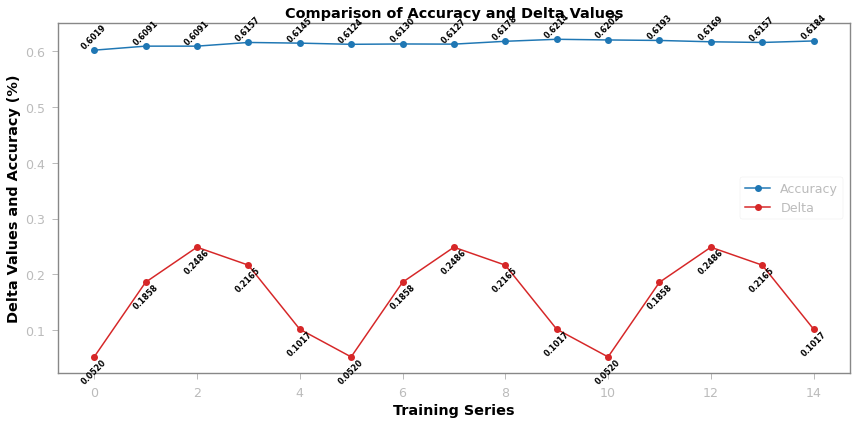

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 46 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6621


epoch,train_loss,valid_loss,accuracy,time
0,7.641420,8.018349,0.600453,01:48


Better model found at epoch 0 with accuracy value: 0.6004531979560852.


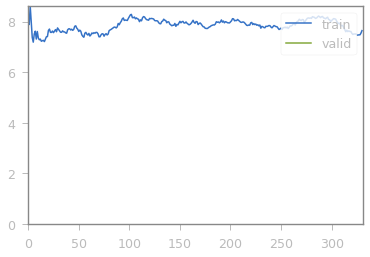

************Round:  0
TTA Accuracy:0.6198619604110718
cycle 0 Error Rate is [{0: (0.6899655017249096, 38.01380395889282)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 38 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6583


epoch,train_loss,valid_loss,accuracy,time
0,8.045414,7.620040,0.621581,01:48


Better model found at epoch 0 with accuracy value: 0.6215805411338806.


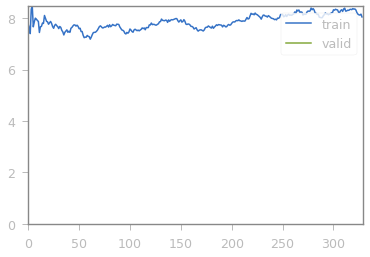

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 37
Min probability = 0.49701492537313435
Dropped 18 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6565


epoch,train_loss,valid_loss,accuracy,time
0,8.033489,7.362090,0.635948,01:47


Better model found at epoch 0 with accuracy value: 0.6359481811523438.


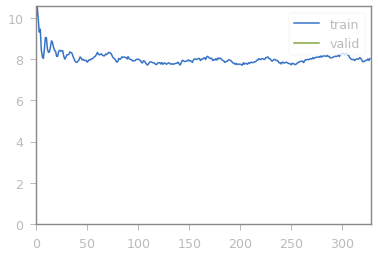

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 34
Min probability = 0.4567164179104478
Dropped 25 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6540


epoch,train_loss,valid_loss,accuracy,time
0,7.730613,7.436983,0.631498,01:47


Better model found at epoch 0 with accuracy value: 0.6314984560012817.


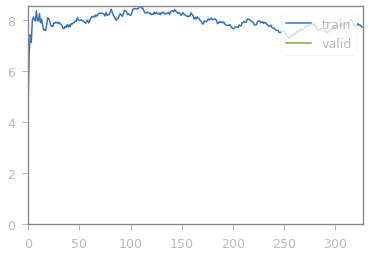

************Round:  3
TTA Accuracy:0.6267626881599426
cycle 0 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 28
Min probability = 0.3761194029850746
Dropped 17 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6523


epoch,train_loss,valid_loss,accuracy,time
0,8.150352,8.153219,0.595092,01:47


Better model found at epoch 0 with accuracy value: 0.5950919985771179.


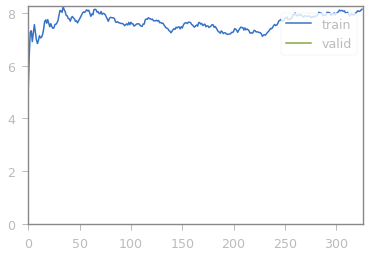

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 23
Min probability = 0.30895522388059704
Dropped 19 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6504


epoch,train_loss,valid_loss,accuracy,time
0,7.470653,7.840754,0.612308,01:47


Better model found at epoch 0 with accuracy value: 0.6123076677322388.


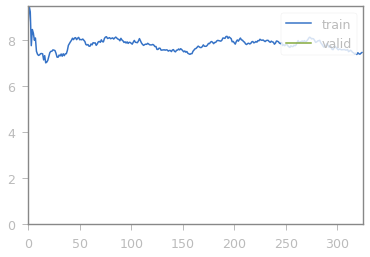

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 18
Min probability = 0.2417910447761194
Dropped 12 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6492


epoch,train_loss,valid_loss,accuracy,time
0,7.866448,7.405663,0.631741,01:46


Better model found at epoch 0 with accuracy value: 0.6317411661148071.


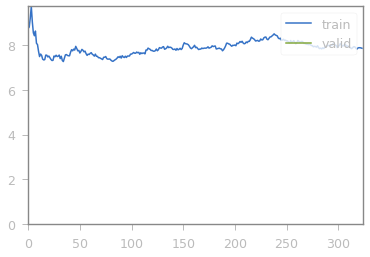

************Round:  6
TTA Accuracy:0.6276627779006958
cycle 0 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 15
Min probability = 0.20149253731343283
Dropped 8 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6484


epoch,train_loss,valid_loss,accuracy,time
0,7.905075,7.617994,0.620370,01:46


Better model found at epoch 0 with accuracy value: 0.6203703880310059.


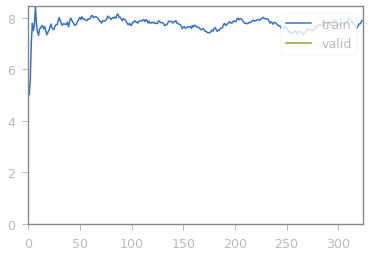

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 15
Min probability = 0.20149253731343283
Dropped 11 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6473


epoch,train_loss,valid_loss,accuracy,time
0,8.250443,7.106531,0.647604,01:46


Better model found at epoch 0 with accuracy value: 0.6476043462753296.


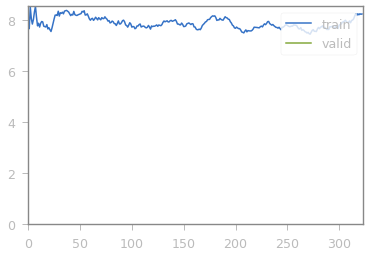

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 13
Min probability = 0.1746268656716418
Dropped 10 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6463


epoch,train_loss,valid_loss,accuracy,time
0,7.848251,7.093263,0.647059,01:47


Better model found at epoch 0 with accuracy value: 0.6470588445663452.


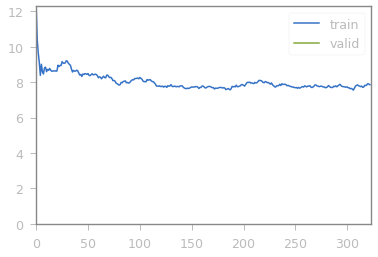

************Round:  9
TTA Accuracy:0.6267626881599426
cycle 0 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 13
Min probability = 0.1746268656716418
Dropped 12 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6451


epoch,train_loss,valid_loss,accuracy,time
0,7.713651,7.327441,0.634109,01:46


Better model found at epoch 0 with accuracy value: 0.6341085433959961.


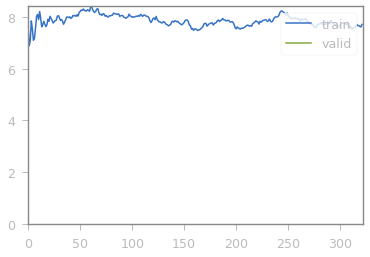

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 13
Min probability = 0.1746268656716418
Dropped 3 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6448


epoch,train_loss,valid_loss,accuracy,time
0,7.744081,7.555278,0.625291,01:46


Better model found at epoch 0 with accuracy value: 0.6252909302711487.


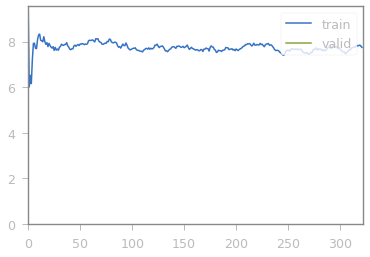

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 12
Min probability = 0.16119402985074627
Dropped 4 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6444


epoch,train_loss,valid_loss,accuracy,time
0,7.638623,7.103702,0.646739,01:46


Better model found at epoch 0 with accuracy value: 0.64673912525177.


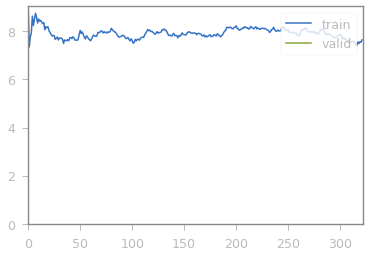

************Round:  12
TTA Accuracy:0.6234623193740845
cycle 0 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 12
Min probability = 0.16119402985074627
Dropped 14 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6430


epoch,train_loss,valid_loss,accuracy,time
0,7.741636,7.549815,0.623639,01:45


Better model found at epoch 0 with accuracy value: 0.6236391663551331.


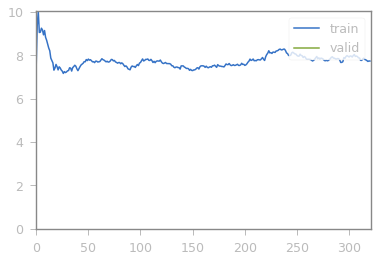

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 12
Min probability = 0.16119402985074627
Dropped 7 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6423


epoch,train_loss,valid_loss,accuracy,time
0,7.927733,6.928401,0.656542,01:45


Better model found at epoch 0 with accuracy value: 0.6565420627593994.


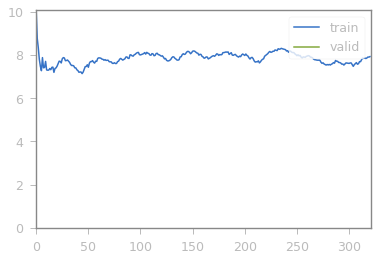

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 44 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6623


epoch,train_loss,valid_loss,accuracy,time
0,8.162122,7.175064,0.642749,01:49


Better model found at epoch 0 with accuracy value: 0.6427492499351501.


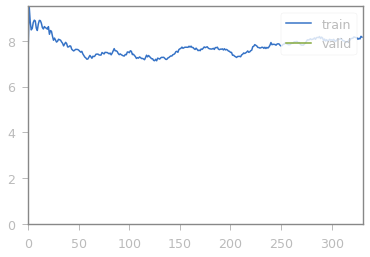

************Round:  0
TTA Accuracy:0.6258625984191895
cycle 1 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155), 15: (0.6599670016499193, 37.413740158081055)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 34 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6589


epoch,train_loss,valid_loss,accuracy,time
0,7.528271,7.760584,0.613516,01:48


Better model found at epoch 0 with accuracy value: 0.6135155558586121.


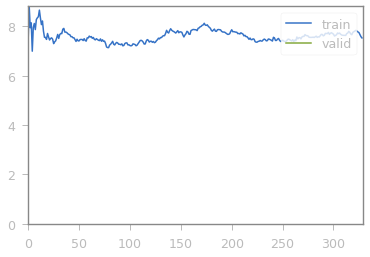

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 41
Min probability = 0.5507462686567164
Dropped 31 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6558


epoch,train_loss,valid_loss,accuracy,time
0,7.882602,7.552994,0.624714,01:48


Better model found at epoch 0 with accuracy value: 0.6247139573097229.


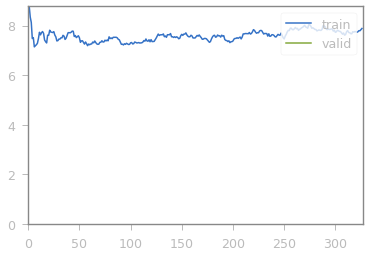

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 37
Min probability = 0.49701492537313435
Dropped 27 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6531


epoch,train_loss,valid_loss,accuracy,time
0,7.256053,7.587523,0.621746,01:47


Better model found at epoch 0 with accuracy value: 0.621745765209198.


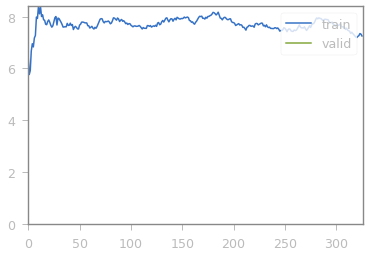

************Round:  3
TTA Accuracy:0.6255625486373901
cycle 1 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155), 15: (0.6599670016499193, 37.413740158081055), 18: (2.0398980050997495, 37.443745136260986)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 31
Min probability = 0.4164179104477612
Dropped 20 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6511


epoch,train_loss,valid_loss,accuracy,time
0,7.708649,7.575336,0.622888,01:47


Better model found at epoch 0 with accuracy value: 0.6228878498077393.


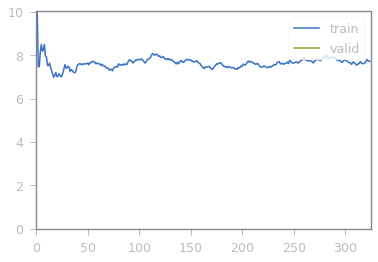

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 28
Min probability = 0.3761194029850746
Dropped 21 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6490


epoch,train_loss,valid_loss,accuracy,time
0,7.526402,7.349120,0.634823,01:46


Better model found at epoch 0 with accuracy value: 0.6348227858543396.


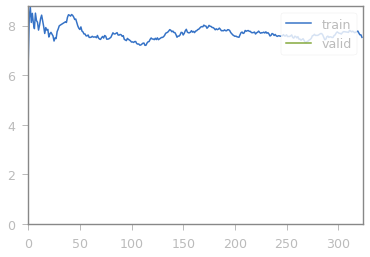

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 22
Min probability = 0.2955223880597015
Dropped 10 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6480


epoch,train_loss,valid_loss,accuracy,time
0,8.003492,7.272061,0.636574,01:46


Better model found at epoch 0 with accuracy value: 0.6365740895271301.


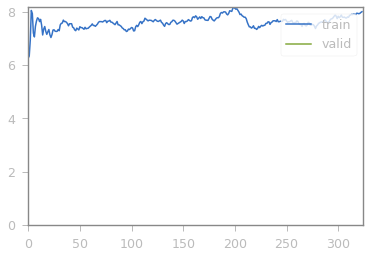

************Round:  6
TTA Accuracy:0.6195619702339172
cycle 1 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155), 15: (0.6599670016499193, 37.413740158081055), 18: (2.0398980050997495, 37.443745136260986), 21: (2.804859757012146, 38.043802976608276)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 20
Min probability = 0.26865671641791045
Dropped 20 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6460


epoch,train_loss,valid_loss,accuracy,time
0,7.648951,7.354580,0.634675,01:46


Better model found at epoch 0 with accuracy value: 0.6346749067306519.


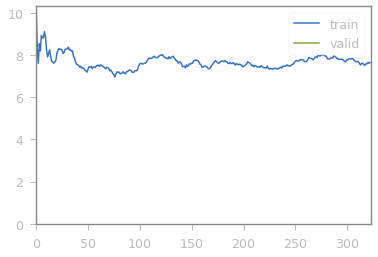

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 18
Min probability = 0.2417910447761194
Dropped 13 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6447


epoch,train_loss,valid_loss,accuracy,time
0,7.599250,7.379854,0.633049,01:45


Better model found at epoch 0 with accuracy value: 0.6330488920211792.


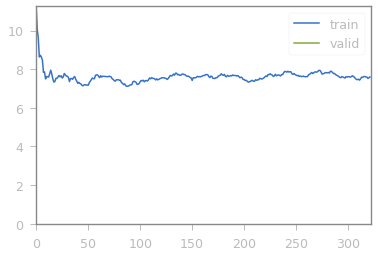

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 17
Min probability = 0.2283582089552239
Dropped 12 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6435


epoch,train_loss,valid_loss,accuracy,time
0,7.627577,8.012824,0.601399,01:45


Better model found at epoch 0 with accuracy value: 0.6013985872268677.


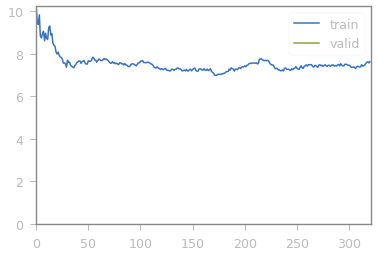

************Round:  9
TTA Accuracy:0.6225622296333313
cycle 1 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155), 15: (0.6599670016499193, 37.413740158081055), 18: (2.0398980050997495, 37.443745136260986), 21: (2.804859757012146, 38.043802976608276), 24: (3.4798260086995603, 37.74377703666687)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 17
Min probability = 0.2283582089552239
Dropped 12 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6423


epoch,train_loss,valid_loss,accuracy,time
0,7.753627,7.304795,0.635514,01:45


Better model found at epoch 0 with accuracy value: 0.6355140209197998.


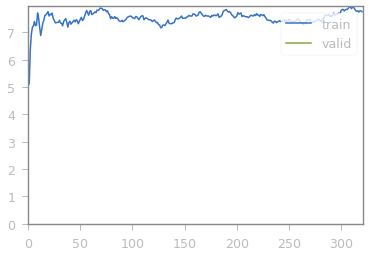

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 15
Min probability = 0.20149253731343283
Dropped 11 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6412


epoch,train_loss,valid_loss,accuracy,time
0,8.067952,7.037585,0.649766,01:46


Better model found at epoch 0 with accuracy value: 0.6497659683227539.


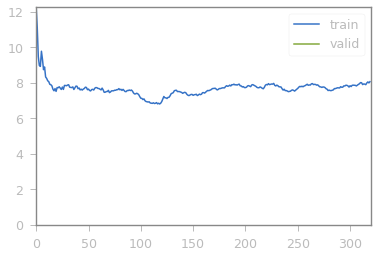

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 14
Min probability = 0.1880597014925373
Dropped 10 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6402


epoch,train_loss,valid_loss,accuracy,time
0,7.539530,7.319322,0.635156,01:45


Better model found at epoch 0 with accuracy value: 0.6351562738418579.


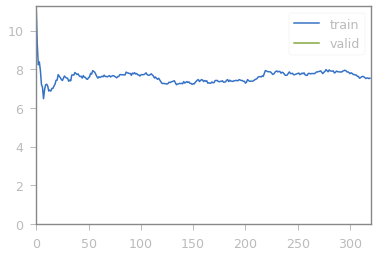

************Round:  12
TTA Accuracy:0.6237623691558838
cycle 1 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155), 15: (0.6599670016499193, 37.413740158081055), 18: (2.0398980050997495, 37.443745136260986), 21: (2.804859757012146, 38.043802976608276), 24: (3.4798260086995603, 37.74377703666687), 27: (3.9748012599369997, 37.62376308441162)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 12
Min probability = 0.16119402985074627
Dropped 9 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6393


epoch,train_loss,valid_loss,accuracy,time
0,7.137064,7.815936,0.611111,01:46


Better model found at epoch 0 with accuracy value: 0.6111111044883728.


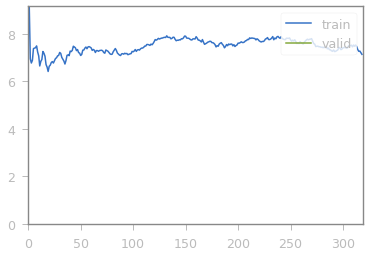

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 11
Min probability = 0.14776119402985075
Dropped 13 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6380


epoch,train_loss,valid_loss,accuracy,time
0,7.670564,7.014958,0.649687,01:45


Better model found at epoch 0 with accuracy value: 0.6496865153312683.


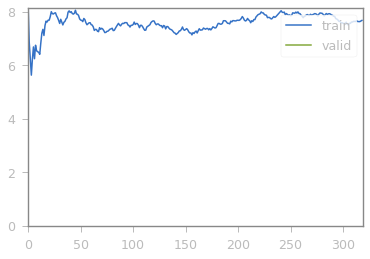

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 43 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6624


epoch,train_loss,valid_loss,accuracy,time
0,7.878675,7.067673,0.648036,01:49


Better model found at epoch 0 with accuracy value: 0.6480362415313721.


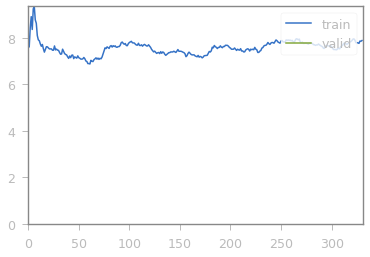

************Round:  0
TTA Accuracy:0.6204620599746704
cycle 2 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155), 15: (0.6599670016499193, 37.413740158081055), 18: (2.0398980050997495, 37.443745136260986), 21: (2.804859757012146, 38.043802976608276), 24: (3.4798260086995603, 37.74377703666687), 27: (3.9748012599369997, 37.62376308441162), 30: (0.6449677516124241, 37.95379400253296)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 37 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6587


epoch,train_loss,valid_loss,accuracy,time
0,7.615468,6.529671,0.675019,01:48


Better model found at epoch 0 with accuracy value: 0.6750189661979675.


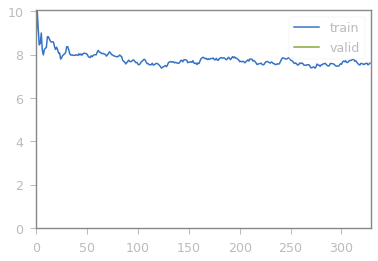

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 41
Min probability = 0.5507462686567164
Dropped 31 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6556


epoch,train_loss,valid_loss,accuracy,time
0,7.163687,6.705238,0.665141,01:47


Better model found at epoch 0 with accuracy value: 0.6651411056518555.


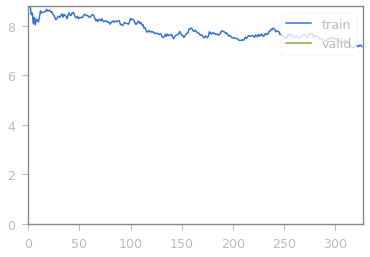

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 33
Min probability = 0.4432835820895522
Dropped 23 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6533


epoch,train_loss,valid_loss,accuracy,time
0,7.631949,7.379704,0.631700,01:47


Better model found at epoch 0 with accuracy value: 0.6316998600959778.


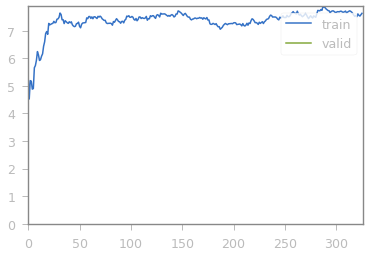

************Round:  3
TTA Accuracy:0.6243624091148376
cycle 2 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155), 15: (0.6599670016499193, 37.413740158081055), 18: (2.0398980050997495, 37.443745136260986), 21: (2.804859757012146, 38.043802976608276), 24: (3.4798260086995603, 37.74377703666687), 27: (3.9748012599369997, 37.62376308441162), 30: (0.6449677516124241, 37.95379400253296), 33: (2.009899505024748, 37.563759088516235)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 30
Min probability = 0.40298507462686567
Dropped 21 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6512


epoch,train_loss,valid_loss,accuracy,time
0,7.572349,7.057930,0.647465,01:47


Better model found at epoch 0 with accuracy value: 0.6474654674530029.


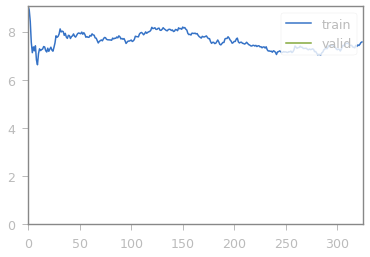

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 28
Min probability = 0.3761194029850746
Dropped 24 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6488


epoch,train_loss,valid_loss,accuracy,time
0,7.167469,8.064660,0.598304,01:46


Better model found at epoch 0 with accuracy value: 0.5983037948608398.


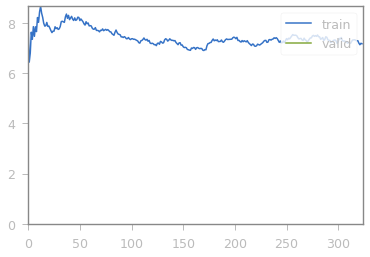

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 22
Min probability = 0.2955223880597015
Dropped 10 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6478


epoch,train_loss,valid_loss,accuracy,time
0,7.234455,7.091135,0.646332,01:46


Better model found at epoch 0 with accuracy value: 0.6463320255279541.


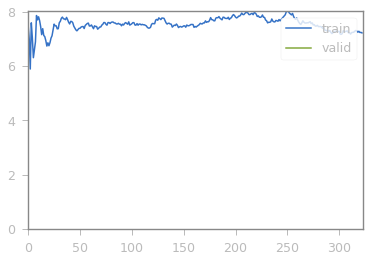

************Round:  6
TTA Accuracy:0.6264626383781433
cycle 2 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155), 15: (0.6599670016499193, 37.413740158081055), 18: (2.0398980050997495, 37.443745136260986), 21: (2.804859757012146, 38.043802976608276), 24: (3.4798260086995603, 37.74377703666687), 27: (3.9748012599369997, 37.62376308441162), 30: (0.6449677516124241, 37.95379400253296), 33: (2.009899505024748, 37.563759088516235), 36: (2.8348582570871472, 37.35373616218567)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 21
Min probability = 0.282089552238806
Dropped 15 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6463


epoch,train_loss,valid_loss,accuracy,time
0,7.515540,7.451197,0.628483,01:46


Better model found at epoch 0 with accuracy value: 0.62848299741745.


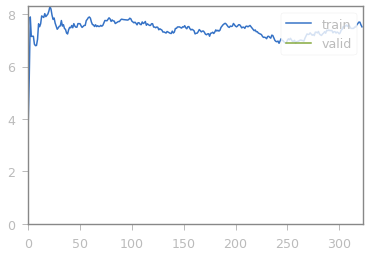

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 19
Min probability = 0.2552238805970149
Dropped 15 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6448


epoch,train_loss,valid_loss,accuracy,time
0,7.283680,7.408814,0.630722,01:46


Better model found at epoch 0 with accuracy value: 0.6307215094566345.


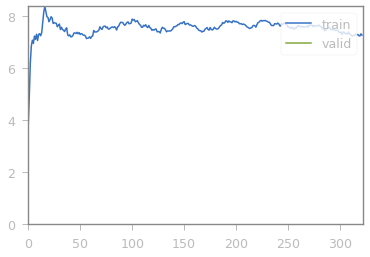

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 18
Min probability = 0.2417910447761194
Dropped 13 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6435


epoch,train_loss,valid_loss,accuracy,time
0,7.553690,7.244847,0.638695,01:46


Better model found at epoch 0 with accuracy value: 0.6386946439743042.


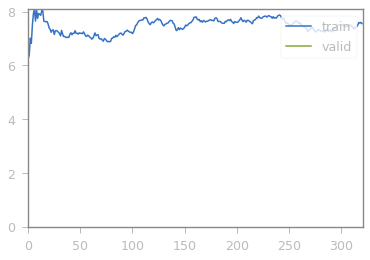

************Round:  9
TTA Accuracy:0.6240624189376831
cycle 2 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155), 15: (0.6599670016499193, 37.413740158081055), 18: (2.0398980050997495, 37.443745136260986), 21: (2.804859757012146, 38.043802976608276), 24: (3.4798260086995603, 37.74377703666687), 27: (3.9748012599369997, 37.62376308441162), 30: (0.6449677516124241, 37.95379400253296), 33: (2.009899505024748, 37.563759088516235), 36: (2.8348582570871472, 37.35373616218567), 39: (3.4798260086995603, 37.59375810623169)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 16
Min probability = 0.21492537313432836
Dropped 8 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6427


epoch,train_loss,valid_loss,accuracy,time
0,7.412433,7.285627,0.637354,01:45


Better model found at epoch 0 with accuracy value: 0.6373540759086609.


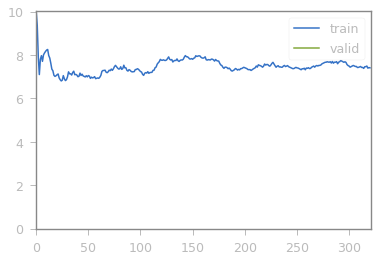

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 15
Min probability = 0.20149253731343283
Dropped 11 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6416


epoch,train_loss,valid_loss,accuracy,time
0,7.625034,7.373153,0.631333,01:45


Better model found at epoch 0 with accuracy value: 0.6313328146934509.


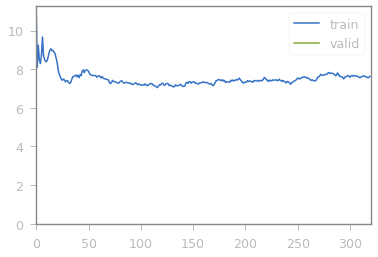

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 14
Min probability = 0.1880597014925373
Dropped 16 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6400


epoch,train_loss,valid_loss,accuracy,time
0,7.239571,7.177343,0.642969,01:45


Better model found at epoch 0 with accuracy value: 0.6429687738418579.


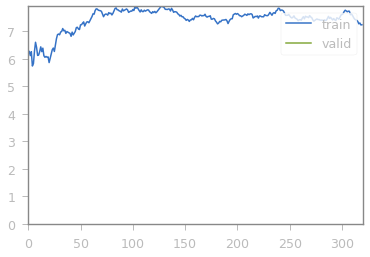

************Round:  12
TTA Accuracy:0.6165616512298584
cycle 2 Error Rate is [{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155), 15: (0.6599670016499193, 37.413740158081055), 18: (2.0398980050997495, 37.443745136260986), 21: (2.804859757012146, 38.043802976608276), 24: (3.4798260086995603, 37.74377703666687), 27: (3.9748012599369997, 37.62376308441162), 30: (0.6449677516124241, 37.95379400253296), 33: (2.009899505024748, 37.563759088516235), 36: (2.8348582570871472, 37.35373616218567), 39: (3.4798260086995603, 37.59375810623169), 42: (4.004799760012001, 38.34383487701416)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 14
Min probability = 0.1880597014925373
Dropped 14 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6386


epoch,train_loss,valid_loss,accuracy,time
0,7.723830,6.810783,0.660141,01:45


Better model found at epoch 0 with accuracy value: 0.6601409316062927.


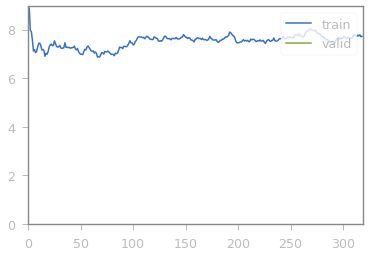

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 14
Min probability = 0.1880597014925373
Dropped 6 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6380


epoch,train_loss,valid_loss,accuracy,time
0,7.309746,7.066043,0.648119,01:44


Better model found at epoch 0 with accuracy value: 0.6481191515922546.


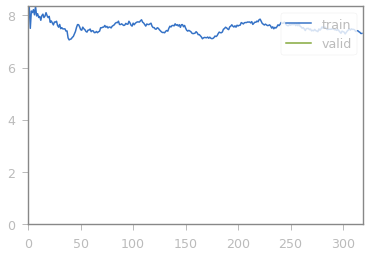

In [32]:
delta_max = 0.50
accs = []
deltas = []
err = {}

for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
#         print(f'delta = {delta}')
        loss_func = losses.DampedMAELossFlat(num_classes=num_classes,scale=20.0, delta = delta, reduction='mean')
     
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
#         print("dynamic LR", dynamic_lr)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
    #     data_per_serie[n+1]
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

    #     learn = ( learner_type(databunch, model,metrics=[accuracy,top_5],loss_func=loss,cbs=[ShowGraphCallback(),history]).to_fp16())
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
#         learn.split( lambda m: (model._conv_head) )
        learn.unfreeze() 
        learn.load(best_pth)
#         learn.fit_one_cycle(epochs_per_serie, max_lr=slice(min_lr,lr),cbs=[SaveModelCallback(learn,metrics=[accuracy], name=best_pth)])
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
#             inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
#             inter_test.plot_confusion_matrix(figsize = (10,10))
            PATH='models/'+damp_2_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_2_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)     
    

In [33]:
# err = {}
print(err)

{0: (0.6899655017249096, 38.01380395889282), 3: (1.90490475476226, 37.32373118400574), 6: (2.624868756562171, 37.23372220993042), 9: (3.0598470076496187, 37.32373118400574), 12: (3.344832758362082, 37.65376806259155), 15: (0.6599670016499193, 37.413740158081055), 18: (2.0398980050997495, 37.443745136260986), 21: (2.804859757012146, 38.043802976608276), 24: (3.4798260086995603, 37.74377703666687), 27: (3.9748012599369997, 37.62376308441162), 30: (0.6449677516124241, 37.95379400253296), 33: (2.009899505024748, 37.563759088516235), 36: (2.8348582570871472, 37.35373616218567), 39: (3.4798260086995603, 37.59375810623169), 42: (4.004799760012001, 38.34383487701416)}


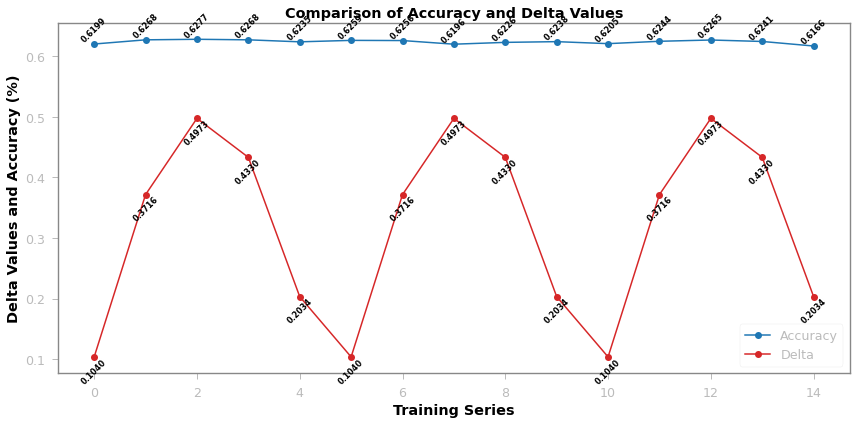

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
